In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
import numpy as np
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from keras.models import Model
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

2025-05-02 18:01:22.318423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746208882.542947      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746208882.608788      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)

train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)  # 27 classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.1245 - loss: 3.0618 - val_accuracy: 0.4361 - val_loss: 2.0422
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.3124 - loss: 2.2484 - val_accuracy: 0.5205 - val_loss: 1.6728
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.3829 - loss: 1.9912 - val_accuracy: 0.5472 - val_loss: 1.5197
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - accuracy: 0.4076 - loss: 1.8805 - val_accuracy: 0.5604 - val_loss: 1.4370
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.4314 - loss: 1.7978 - val_accuracy: 0.5753 - val_loss: 1.4012
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 126ms/step - accuracy: 0.4540 - loss: 1.7238 - val_accuracy: 0.5937 - val_loss: 1.3473
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.4603 - loss: 1.6998 - val_accuracy: 0.6071 - val_loss: 1.2981
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.4719 - loss: 1

In [10]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6187 - loss: 1.2311
Validation Accuracy: 61.65%
Validation Loss: 1.2399


In [11]:
# After initial training
base_model.trainable = True

# Unfreeze last 4 blocks of VGG16
for layer in base_model.layers[:15]:
    layer.trainable = False

# Use lower learning rate for fine-tuning
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 29,288,339 (111.73 MB)

 Trainable params: 7,217,691 (27.53 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,435,384 (55.07 MB)

In [12]:
# 5. Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.5363 - loss: 1.4218 - val_accuracy: 0.7308 - val_loss: 0.8091
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 72s 124ms/step - accuracy: 0.6312 - loss: 1.0979 - val_accuracy: 0.7790 - val_loss: 0.6672
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 123ms/step - accuracy: 0.6855 - loss: 0.9341 - val_accuracy: 0.8154 - val_loss: 0.5601
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 123ms/step - accuracy: 0.7175 - loss: 0.8319 - val_accuracy: 0.8439 - val_loss: 0.4920
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 123ms/step - accuracy: 0.7492 - loss: 0.7454 - val_accuracy: 0.8610 - val_loss: 0.4426
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 123ms/step - accuracy: 0.7703 - loss: 0.6817 - val_accuracy: 0.8700 - val_loss: 0.4035
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 70s 122ms/step - accuracy: 0.7844 - loss: 0.6344 - val_accuracy: 0.8759 - val_loss: 0.3836
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 71s 123ms/step - accuracy: 0.7954 - loss: 0

In [13]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9031 - loss: 0.2960
Validation Accuracy: 90.77%
Validation Loss: 0.2880


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create submodel that maps input to last conv layer + predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradients of top predicted class w.r.t. output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap generation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)  # ReLU
      # Normalize
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Normalize heatmap to [0, 255] and convert to uint8
    heatmap = np.uint8(255 * heatmap / np.max(heatmap + 1e-8))  # avoid divide-by-zero

    # Apply the Jet colormap
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]  # shape: (H, W, 3), float32 [0, 1]

    # Resize heatmap to match original image size
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    # Convert original image to float [0, 1] if it's not already
    if img.max() > 1.0:
        img = img / 255.0

    # Blend image with


143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step


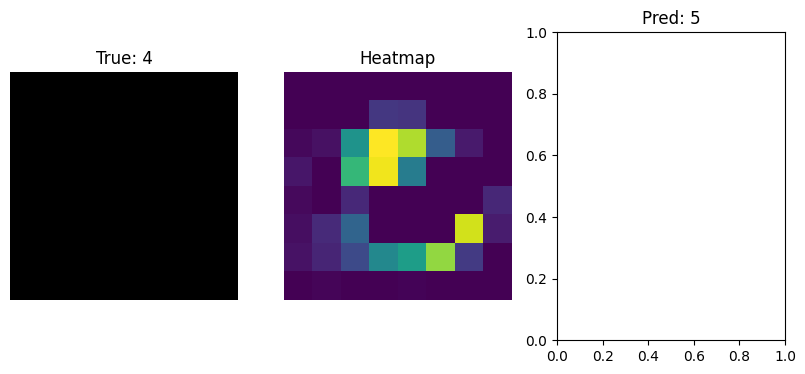

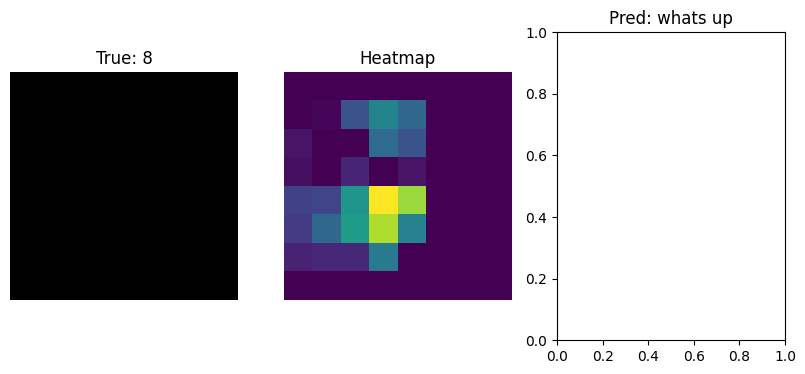

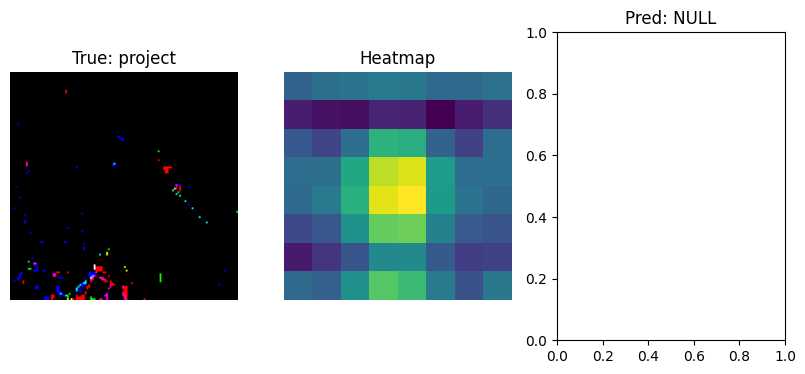

In [37]:
# Get sample misclassified images from validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Choose first 3 misclassified examples
for i in misclassified_indices[:3]:
    # Get image and preprocess
    img = X_val[i]
    img_array = np.expand_dims(img, axis=0)
    
    # Generate heatmap
    last_conv_layer_name = "block5_conv3"  # Last conv layer in VGG16
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # Prepare original image
    img_for_display = X_val[i].astype('uint8')  # Original non-preprocessed image
    
    # Display results
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_for_display)
    plt.title(f"True: {label_encoder.inverse_transform([y_true_classes[i]])[0]}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    display_gradcam(img_for_display, heatmap)
    plt.title(f"Pred: {label_encoder.inverse_transform([y_pred_classes[i]])[0]}")
    
    plt.show()

143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


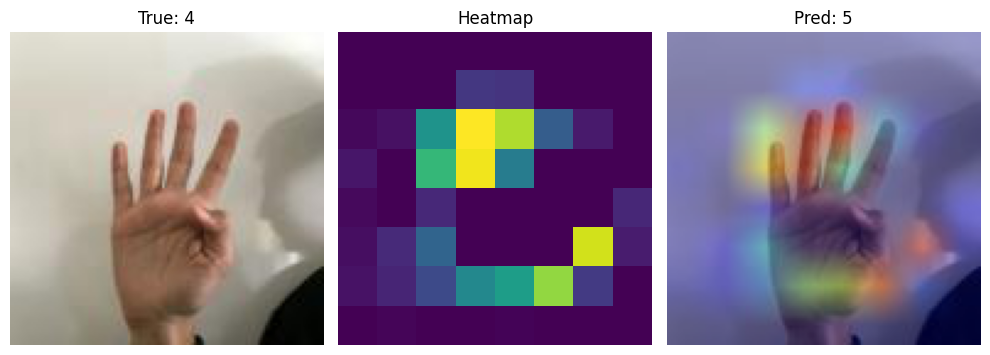

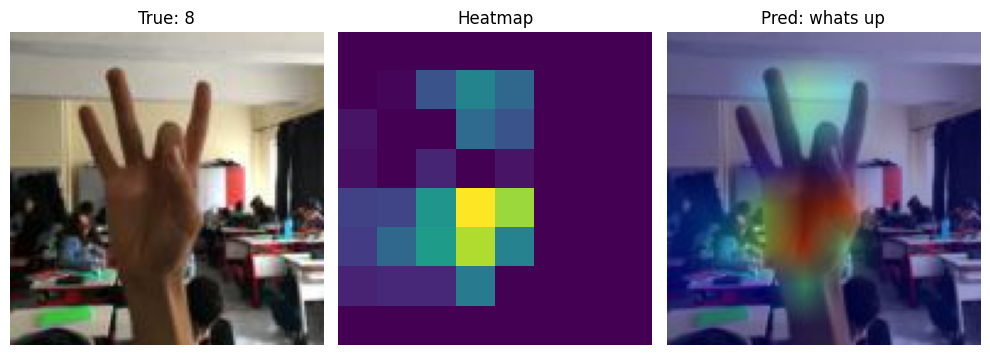

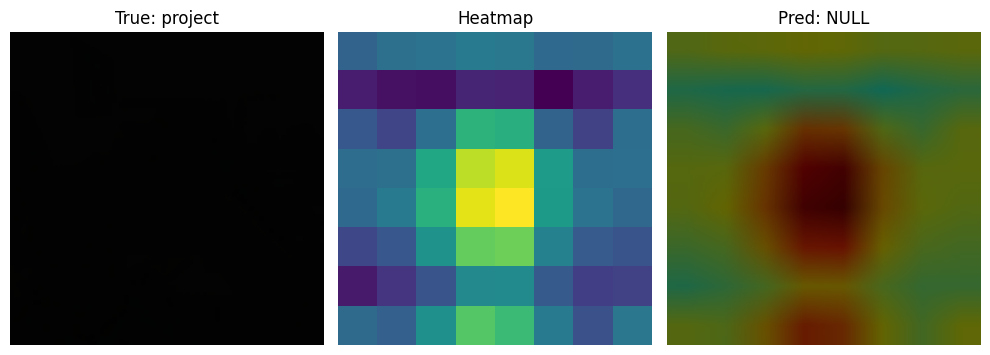

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# --- Grad-CAM heatmap generation ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

# --- Grad-CAM visualization ---
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    if img.max() <= 1.0:
        img = img * 255
    img = img.astype(np.uint8)

    superimposed_img = (1 - alpha) * img / 255.0 + alpha * jet_heatmap
    superimposed_img = np.clip(superimposed_img * 255, 0, 255).astype(np.uint8)

    plt.imshow(superimposed_img)
    plt.axis('off')
    return superimposed_img

# --- Prediction + misclassification handling ---
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# --- Show first 3 misclassified examples ---
for i in misclassified_indices[:3]:
    img = X_val[i]
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='block5_conv3')
    
    img_for_display = img
    if img_for_display.max() <= 1.0:
        img_for_display = (img_for_display * 255).astype(np.uint8)

    pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_for_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    display_gradcam(img_for_display, heatmap)
    plt.title(f"Pred: {pred_label}")

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

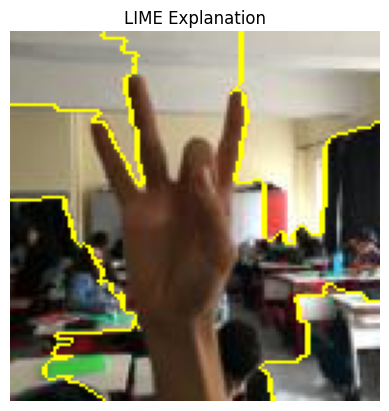

In [45]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


In [47]:
!pip install SHAP 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

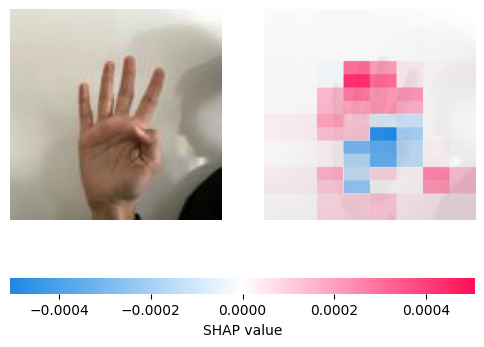

In [56]:
import shap
from shap.maskers import Image
import numpy as np

# Select image(s) you want to explain
test_images = X_val[misclassified_indices[:1]]  # just one image

# Choose class to explain — e.g., predicted class
preds = model.predict(test_images)
pred_class = np.argmax(preds[0])  # single class index

# Create image masker
masker = Image("blur(128,128)", test_images[0].shape)


# Create SHAP explainer
explainer = shap.Explainer(
    lambda x: model.predict(x)[:, pred_class],  # target one class
    masker
)

# Compute SHAP values for just that class
shap_values = explainer(test_images)

# Plot
shap.plots.image(shap_values)


In [60]:
import numpy as np
import matplotlib.pyplot as plt

def feature_ablation_heatmap(image, model, class_idx=None, patch_size=20):
    img = image.copy()
    h, w, c = img.shape

    # Number of patches in height and width
    n_patches_y = h // patch_size
    n_patches_x = w // patch_size

    heatmap = np.zeros((n_patches_y, n_patches_x))

    # Get original prediction
    orig_pred = model.predict(img[None])[0]
    if class_idx is None:
        class_idx = np.argmax(orig_pred)
    orig_conf = orig_pred[class_idx]

    for i in range(n_patches_y):
        for j in range(n_patches_x):
            occluded = img.copy()
            y_start = i * patch_size
            x_start = j * patch_size

            # Mask out the patch with gray (0.5)
            occluded[y_start:y_start+patch_size, x_start:x_start+patch_size, :] = 0.5

            # Predict
            occl_pred = model.predict(occluded[None])[0][class_idx]
            delta = orig_conf - occl_pred
            heatmap[i, j] = delta

    # Resize heatmap to original image dimensions
    heatmap_resized = np.kron(heatmap, np.ones((patch_size, patch_size)))

    # If image size isn't divisible by patch_size, crop the heatmap to fit
    heatmap_resized = heatmap_resized[:h, :w]

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title("Feature Ablation Map")
    plt.colorbar(label="Drop in confidence")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

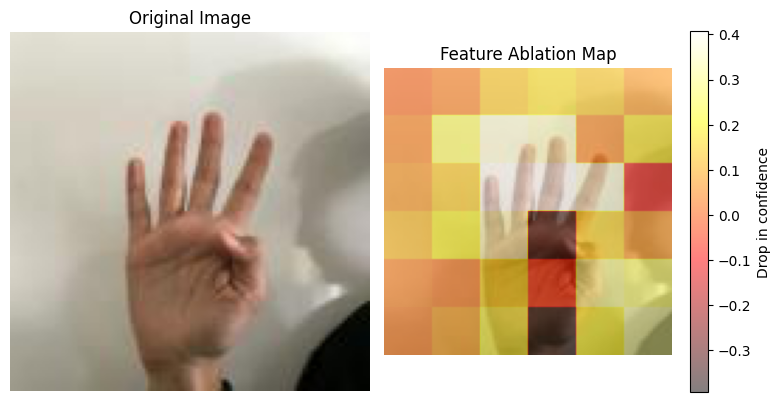

In [61]:
# Assume test_images[0] is your misclassified image
feature_ablation_heatmap(test_images[0], model)
